In [6]:
# !pip install dask 
# !pip install imblearn
# !pip install catboost
# !python -m pip install 'fsspec>=0.3.3'


     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 133 kB 21.9 MB/s 


In [1]:
import pandas as pd
import numpy as np
# import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(9,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
%%time

train = pd.read_csv('/content/drive/MyDrive/megafon/data/train_merged_pca.csv')
test = pd.read_csv('/content/drive/MyDrive/megafon/data/test_merged_pca.csv')


CPU times: user 13.4 s, sys: 1.53 s, total: 14.9 s
Wall time: 16.6 s


In [7]:
train.head()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2582523,2.0,1531083600,0.0,0.0,-0.379565,3.028142,-3.500371,1.187461,1.037129,-5.820157,-2.433865,0.993170,-2.774625,-0.556117,-1.629128,0.715854,0.017914,-1.447724,1.508394,-0.822844,0.419529,-0.083012,1.799970,-3.253042,-1.298325,0.037649,-0.689052,-1.055749,-0.056663,0.412884,-1.176714,-0.520739,0.427939,-0.513427,0.459595,0.730665,0.265969,-1.284101,1.202873,0.875026,-0.536406,0.632330,-0.475059,-0.870865,1.002739,0.263111,-0.435263,1.549308,-1.782069,-1.105894,-0.891954,0.241378,0.041470,-0.847622
1,1292549,2.0,1531083600,0.0,0.0,-0.732555,-1.241620,0.808876,-1.112869,-0.056170,0.647828,-0.310328,-0.001160,-0.091243,-1.951585,0.502413,1.251389,-0.025906,0.115367,1.045803,-1.504904,0.851506,0.160906,1.258476,-0.121328,-0.235632,0.036044,0.102688,0.124349,-0.052449,0.298715,-0.564489,-0.171412,0.323695,-0.462932,0.064164,-0.141937,0.086651,-0.025348,0.119951,-0.029222,-0.023365,0.057787,0.373685,0.792557,-0.160786,-0.395541,-0.883232,-0.790913,0.155308,-1.031596,1.128488,-0.054172,-0.432766,-0.587913
2,4053116,1.0,1531083600,0.0,1.0,-4.904805,1.398003,-1.793186,4.859256,2.093246,-9.645993,1.429414,0.545919,0.174208,-1.479165,-1.092840,1.580945,-0.221099,1.378098,1.692363,0.519615,0.336697,-0.595411,0.577373,-3.688381,-0.176124,-0.027954,-0.038586,-0.378160,0.538854,-0.749864,-0.709315,0.527764,0.097938,-0.441398,0.172043,-0.069156,0.305433,-2.576501,-0.518498,-0.550323,-0.489316,-0.101964,0.061430,-0.119779,0.227615,-0.612525,0.268357,0.206455,-0.924363,-1.556419,-1.225303,0.336331,1.378801,-1.779163
3,4158361,2.0,1531083600,0.0,1.0,0.738585,-0.327294,-0.920619,-0.507506,-0.035862,0.248360,0.020649,0.175320,-0.352958,-0.824446,0.729942,2.055860,0.194477,-1.901824,-0.715619,1.437749,-0.771436,-0.803192,0.332368,0.222889,-0.957035,0.044355,-0.009415,-0.298695,0.058135,0.442553,0.168446,0.491384,-0.682939,0.197005,-0.096129,-0.730208,-0.328578,-0.102342,0.581265,0.272101,-0.411394,0.405110,0.497813,-0.101720,0.920590,-0.710220,-1.096233,-0.298477,0.576943,-0.538938,0.229892,-0.132580,0.933606,0.867556
4,3754468,4.0,1531083600,0.0,0.0,2.087168,0.021381,2.561606,-0.447806,-0.265248,0.104849,2.129108,1.328199,-1.835479,-1.527131,1.990753,-1.202331,-0.274928,2.507410,-0.741007,-1.966617,1.017902,-0.899955,-0.257205,0.069762,-0.982659,0.086172,0.218080,0.110811,-0.920144,0.013109,-0.972918,0.094029,1.289324,-1.059118,0.380219,2.353710,0.124683,0.183673,0.434873,-1.121534,0.984089,-0.475966,-0.119720,2.669304,-1.033349,-0.867090,-0.569756,0.052730,-0.848584,2.657796,-2.327419,0.606161,-0.487402,0.261275


In [8]:
test.head()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2905850,5.0,1546808400,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,-3.068522,0.732860,-2.189637,-2.162039,0.025189,1.007126,-0.135843,-1.037486,2.136340,0.274160,0.023051,1.019656,1.349901,0.122159,-0.588040,0.125606,0.287741,0.332373,-0.013333,0.368669,-0.622561,0.038953,-0.329741,0.011039,-0.243925,-0.675803,0.068222,0.038998,0.044122,-0.403943,0.255999,-0.125215,-0.074913,0.402864,-0.582579,0.332824,-0.258431,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542
1,31619,2.0,1546808400,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,0.446351,-0.135912,0.686435,0.689736,1.107887,-1.144757,-0.057569,-0.038473,0.164809,0.872651,-0.340341,0.457728,0.168917,-0.329007,0.713021,-0.101581,1.028483,0.331790,0.106632,-0.075537,0.598681,1.344529,-0.289204,0.617015,0.392704,0.566519,-1.331484,0.353970,-1.291729,0.475039,-0.214171,-0.653872,0.439175,0.210711,-0.774290,0.718145,-0.916016,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177
2,1427271,6.0,1546808400,0.0,-3.459511,2.924535,-1.996942,1.149771,0.273366,-1.354597,0.343925,0.769168,0.767604,1.737281,2.515494,-3.263324,-0.274025,-2.630465,-1.240555,0.093915,-0.245080,-2.358221,0.978927,-0.788225,-0.129277,-0.127562,0.505541,-0.989789,-0.116316,0.369631,-0.574013,0.815299,-0.689967,-0.601930,-0.676840,0.085525,1.268771,-0.005281,0.306810,0.287581,0.143507,0.555442,-1.534869,-0.219562,0.241564,1.047118,1.576573,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983
3,2162521,6.0,1546808400,0.0,-0.421286,-1.363834,1.143938,-1.366164,0.200698,-0.374600,-4.414243,-0.408097,1.301462,2.018216,-1.320006,-1.752324,-0.163369,0.895663,-0.557005,-0.997023,0.482234,-0.771327,0.865249,0.451514,0.948337,-0.180128,1.035654,-0.150938,0.161255,-0.340835,0.344446,-0.327384,-0.319412,0.420566,-0.062517,0.309923,-0.096476,-0.199471,0.479791,-0.021861,-0.031904,0.588495,-0.349279,-0.407276,0.315521,0.168451,0.166489,-0.734784,-0.499309,-0.123867,0.424443,0.042869,-0.159201,-0.530986
4,1529304,6.0,1546808400,1.0,-4.070811,-1.120186,1.827899,0.396192,-0.248577,0.608398,1.641528,-0.236439,0.024917,1.321882,0.770157,-0.846279,-0.037787,0.372636,0.894682,-0.562812,0.343056,0.195846,-0.053727,-0.075486,-0.778408,0.018543,0.178579,0.302308,-0.294951,0.542799,-0.680034,0.808088,0.602389,-0.314476,0.616920,0.635329,-0.471028,0.298313,-0.311924,-0.096701,-0.025833,-0.269457,0.807805,1.403430,0.395898,-0.747956,-1.003190,1.532903,1.056886,0.202940,0.059298,-0.193865,0.658619,0.539136


In [9]:
train.describe()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
count,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000
mean,2.158304e+06,2.686185,1.538937e+09,0.072369,0.258348,-2.973488e-07,-0.000002,-0.000003,-7.521257e-07,0.000002,-0.000002,4.150825e-07,0.000002,3.657246e-08,0.000002,-5.765002e-07,0.000001,-0.000002,5.092446e-07,-4.784930e-07,0.000003,0.000001,-0.000004,0.000004,-0.000007,-0.000003,-0.000005,7.628454e-07,0.000002,-0.000004,-0.000004,0.000001,-0.000005,0.000003,7.880808e-08,0.000002,-0.000002,0.000003,-0.000002,-3.021881e-07,0.000002,-9.064867e-07,-0.000004,-4.247727e-07,-0.000002,-0.000006,0.000002,0.000003,-5.026830e-07,-0.000003,-0.000002,0.000001,-7.364982e-08,0.000002,-0.000002
std,1.257907e+06,1.952034,5.019053e+06,0.259098,2.095543,4.168477e+00,3.196697,2.754510,2.608547e+00,2.401133,2.336768,2.106173e+00,2.069186,2.007525e+00,1.925666,1.913549e+00,1.887471,1.837944,1.769596e+00,1.750613e+00,1.711555,1.699946,1.688178,1.633249,1.611117,1.571509,1.531479,1.507986e+00,1.499972,1.477026,1.447584,1.438623,1.410198,1.393798,1.384341e+00,1.381133,1.375055,1.354927,1.348116,1.331988e+00,1.326720,1.321399e+00,1.296373,1.290012e+00,1.267721,1.257200,1.240602,1.232778,1.214146e+00,1.186233,1.182909,1.161123,1.155322e+00,1.144133,1.128467
min,2.000000e+00,1.000000,1.531084e+09,0.000000,0.000000,-1.883192e+01,-21.062065,-280.728360,-3.856438e+02,-436.865900,-112.504920,-5.569805e+01,-663.325400,-1.361045e+02,-95.122720,-2.857864e+02,-135.578830,-25.047516,-1.054746e+02,-1.621865e+02,-141.141020,-29.731540,-244.086730,-145.546300,-96.263550,-164.824300,-24.931883,-1.691627e+02,-242.862610,-284.878970,-163.604580,-152.161420,-86.944664,-52.054440,-7.676002e+01,-309.305500,-61.037872,-137.513730,-132.049730,-1.228654e+02,-116.619156,-7.065615e+01,-118.784220,-8.871464e+01,-67.837410,-153.830750,-134.932510,-92.144970,-8.327443e+01,-97.050280,-69.493126,-85.852130,-1.893339e+02,-175.377000,-112.403180
25%,1.067319e+06,1.000000,1.534108e+09,0.000000,0.000000,-2.851814e+00,-1.138848,-0.434562,-9.634501e-01,-0.327457,-0.308661,-1.269880e+00,-0.560772,-1.085892e+00,-0.958062,-6.803331e-01,-1.031512,-0.136121,-6.779326e-01,-7.493726e-01,-0.750884,-0.444751,-0.547961,-0.715073,-0.178011,-0.664616,-0.100410,-5.649106e-01,-0.167382,-0.148801,-0.289423,-0.505521,-0.458163,-0.459544,-5.243153e-01,-0.224031,-0.608123,-0.559665,-0.305026,-3.029930e-01,-0.418207,-3.100477e-01,-0.239299,-3.790631e-01,-0.452209,-0.354765,-0.324709,-0.538845,-5.906512e-01,-0.343207,-0.552736,-0.523569,-1.919642e-01,-0.292515,-0.416239
50%,2.144574e+06,2.000000,1.538341e+09,0.000000,0.000000,-4.483528e-01,-0.519214,0.651869,-2.572167e-01,-0.115142,0.360576,1.66103

In [10]:
train.target.value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [11]:
test.head()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2905850,5.0,1546808400,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,-3.068522,0.732860,-2.189637,-2.162039,0.025189,1.007126,-0.135843,-1.037486,2.136340,0.274160,0.023051,1.019656,1.349901,0.122159,-0.588040,0.125606,0.287741,0.332373,-0.013333,0.368669,-0.622561,0.038953,-0.329741,0.011039,-0.243925,-0.675803,0.068222,0.038998,0.044122,-0.403943,0.255999,-0.125215,-0.074913,0.402864,-0.582579,0.332824,-0.258431,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542
1,31619,2.0,1546808400,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,0.446351,-0.135912,0.686435,0.689736,1.107887,-1.144757,-0.057569,-0.038473,0.164809,0.872651,-0.340341,0.457728,0.168917,-0.329007,0.713021,-0.101581,1.028483,0.331790,0.106632,-0.075537,0.598681,1.344529,-0.289204,0.617015,0.392704,0.566519,-1.331484,0.353970,-1.291729,0.475039,-0.214171,-0.653872,0.439175,0.210711,-0.774290,0.718145,-0.916016,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177
2,1427271,6.0,1546808400,0.0,-3.459511,2.924535,-1.996942,1.149771,0.273366,-1.354597,0.343925,0.769168,0.767604,1.737281,2.515494,-3.263324,-0.274025,-2.630465,-1.240555,0.093915,-0.245080,-2.358221,0.978927,-0.788225,-0.129277,-0.127562,0.505541,-0.989789,-0.116316,0.369631,-0.574013,0.815299,-0.689967,-0.601930,-0.676840,0.085525,1.268771,-0.005281,0.306810,0.287581,0.143507,0.555442,-1.534869,-0.219562,0.241564,1.047118,1.576573,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983
3,2162521,6.0,1546808400,0.0,-0.421286,-1.363834,1.143938,-1.366164,0.200698,-0.374600,-4.414243,-0.408097,1.301462,2.018216,-1.320006,-1.752324,-0.163369,0.895663,-0.557005,-0.997023,0.482234,-0.771327,0.865249,0.451514,0.948337,-0.180128,1.035654,-0.150938,0.161255,-0.340835,0.344446,-0.327384,-0.319412,0.420566,-0.062517,0.309923,-0.096476,-0.199471,0.479791,-0.021861,-0.031904,0.588495,-0.349279,-0.407276,0.315521,0.168451,0.166489,-0.734784,-0.499309,-0.123867,0.424443,0.042869,-0.159201,-0.530986
4,1529304,6.0,1546808400,1.0,-4.070811,-1.120186,1.827899,0.396192,-0.248577,0.608398,1.641528,-0.236439,0.024917,1.321882,0.770157,-0.846279,-0.037787,0.372636,0.894682,-0.562812,0.343056,0.195846,-0.053727,-0.075486,-0.778408,0.018543,0.178579,0.302308,-0.294951,0.542799,-0.680034,0.808088,0.602389,-0.314476,0.616920,0.635329,-0.471028,0.298313,-0.311924,-0.096701,-0.025833,-0.269457,0.807805,1.403430,0.395898,-0.747956,-1.003190,1.532903,1.056886,0.202940,0.059298,-0.193865,0.658619,0.539136


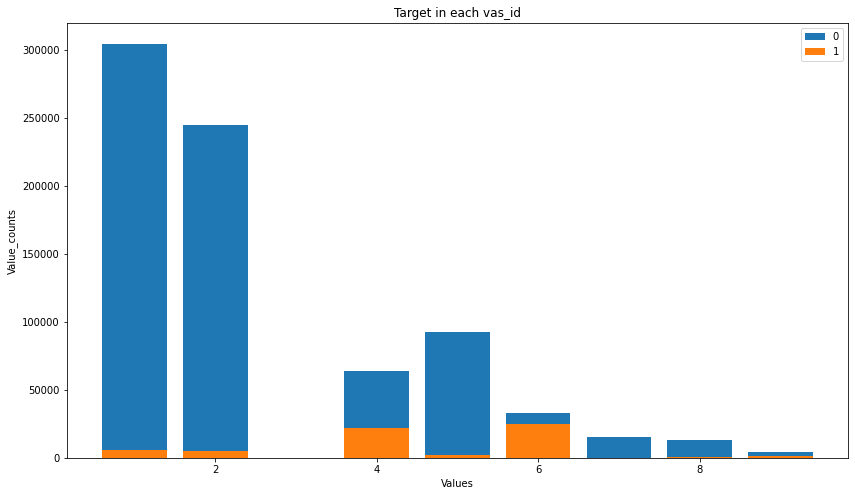

In [12]:
plt.figure(figsize=(14, 8))

vas_ids_1 = train.loc[train.target==1].vas_id.value_counts().sort_values()
vas_ids_0 = train.loc[train.target==0].vas_id.value_counts().sort_values()

plt.bar(vas_ids_0.index, vas_ids_0.values, label='0', )
plt.bar(vas_ids_1.index, vas_ids_1.values, label='1')

plt.title('Target in each vas_id')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

### Работа с временным признаком

Переконвертируем колонку в привычный формат даты, чтобы было удобно с ней работать. Из колонки создадим признаки и по ним посмотрим на распределение целевой переменной

In [13]:
train['buy_time'] = pd.to_datetime(train['buy_time'], unit='s')
test['buy_time'] = pd.to_datetime(test['buy_time'], unit='s')
test.sample()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
58611,3452747,2.0,2019-01-20 21:00:00,0.0,11.101398,6.650715,-27.032583,-1.50154,1.632095,4.266353,3.920646,-4.553184,0.969494,-2.822311,-4.23932,-1.893684,-0.381796,4.65439,0.83161,0.464719,0.376744,4.24243,1.771924,-1.4942,4.546318,-0.684913,4.215007,-0.692775,-1.052207,5.224163,-6.811355,3.535824,-0.575896,0.78599,0.272518,5.195571,1.922173,3.518715,-1.878398,-0.048456,-7.149651,4.648919,4.43891,0.906962,4.534119,5.131702,1.872963,-4.294121,-0.234194,-3.26281,-5.343455,1.125935,-5.394097,-3.529997


In [14]:
pd.DatetimeIndex(train['buy_time']).year.unique().values

array([2018])

In [15]:
# Посмотрим на количество уникальных значений года и часа
print(f"Год (train): {pd.DatetimeIndex(train['buy_time']).year.unique().values}", 
      f"Год (test): {pd.DatetimeIndex(test['buy_time']).year.unique().values}", 
      f"Час (train): {pd.DatetimeIndex(train['buy_time']).hour.unique().values}", 
      f"Час (test): {pd.DatetimeIndex(test['buy_time']).hour.unique().values}", sep='\n')


Год (train): [2018]
Год (test): [2019]
Час (train): [21]
Час (test): [21]


Видно, что наблюдения в обеих выборках принимают только одно значение, по-этому эти столбцы не дадут никакой информации для модели. Создадим колонки месяц и день и проанализируем значения

In [16]:
train['month'] = pd.DatetimeIndex(train['buy_time']).month
test['month'] = pd.DatetimeIndex(test['buy_time']).month

train['day'] = pd.DatetimeIndex(train['buy_time']).day
test['day'] = pd.DatetimeIndex(test['buy_time']).day

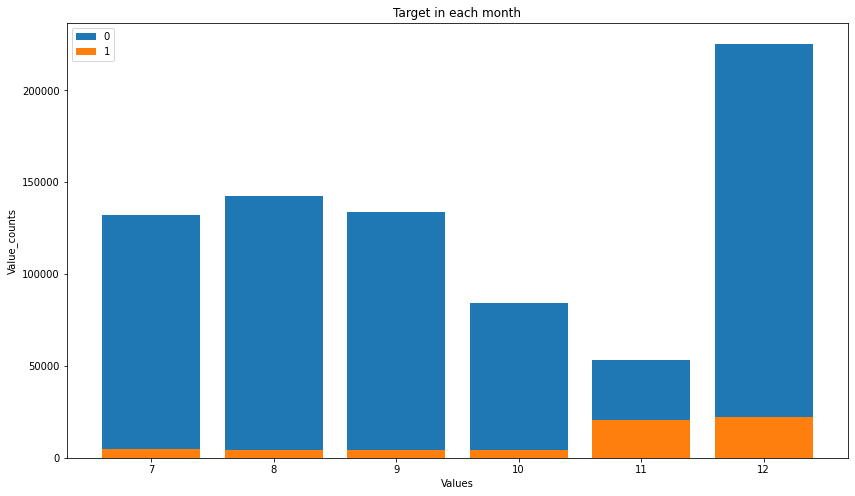

In [17]:
plt.figure(figsize=(14, 8))

months_1 = train.loc[train.target==1].month.value_counts().sort_values()
months_0 = train.loc[train.target==0].month.value_counts().sort_values()

plt.bar(months_0.index, months_0.values, label='0')
plt.bar(months_1.index, months_1.values, label='1')

plt.title('Target in each month')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

In [18]:
for month in train.month.unique():
  print(f'For month # {month}')
  print(train.loc[train.month==month].target.value_counts(normalize=True))

For month # 7
0.0    0.965906
1.0    0.034094
Name: target, dtype: float64
For month # 8
0.0    0.971949
1.0    0.028051
Name: target, dtype: float64
For month # 9
0.0    0.969003
1.0    0.030997
Name: target, dtype: float64
For month # 10
0.0    0.950052
1.0    0.049948
Name: target, dtype: float64
For month # 11
0.0    0.721382
1.0    0.278618
Name: target, dtype: float64
For month # 12
0.0    0.910324
1.0    0.089676
Name: target, dtype: float64


Видно, что во всех месяцах, кроме 11 вероятность появления целевого класса  более-менее похожа. Посмотрим, как распределен таргет по дням

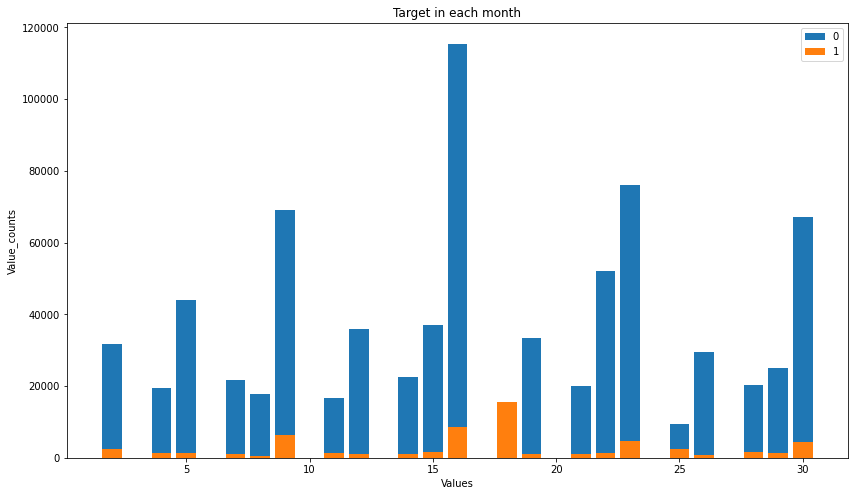

In [19]:
plt.figure(figsize=(14, 8))

days_1 = train.loc[train.target==1].day.value_counts().sort_values()
days_0 = train.loc[train.target==0].day.value_counts().sort_values()

plt.bar(days_0.index, days_0.values, label='0', )
plt.bar(days_1.index, days_1.values, label='1')

plt.title('Target in each month')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

In [20]:
train.loc[train.day==18].target.value_counts()

1.0    15418
0.0     7497
Name: target, dtype: int64

In [21]:
test.loc[test.day==18]

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day


18 числа в тесте нет, при этом в трейне наблюдается аномалия по таргету в этот день, посмотрим, в каком месяце наблюдались такие значения

In [22]:
train.loc[train.day==18].month.value_counts()

11    22915
Name: month, dtype: int64

Возможно, эта дата дает такое смещение в 11 месяце. Посмотрим на распределение таргета в 11 месяце без 18 числа

In [23]:
 train.loc[~(train.day==18) & (train.month==11)].target.value_counts(normalize=True)

0.0    0.899891
1.0    0.100109
Name: target, dtype: float64

теперь выглядит более адекватно (но все равно выбивается из картины предыдущих трех месяцев. Сначала попробуем обучить модель без 18.11). Посмотрим на распределение по дням в каждом месяце

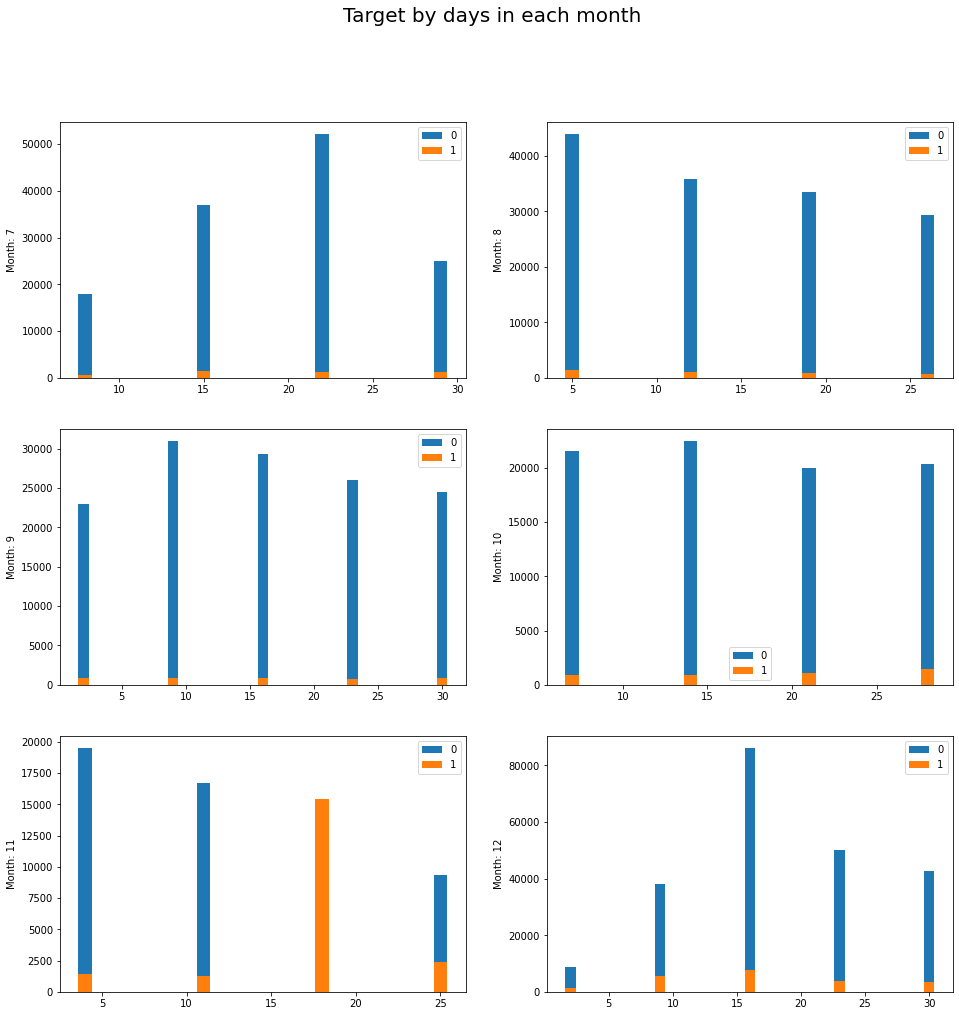

In [24]:
months = np.sort(train.month.unique())
fig=plt.figure(figsize=(16, 16))

plt.suptitle("Target by days in each month", size=20)
i=0
for month_ in months:
    
    days_1 = train.loc[(train.target==1) & (train.month==month_)].day.value_counts().sort_values()
    days_0 = train.loc[(train.target==0) & ((train.month==month_))].day.value_counts().sort_values()
    
    ax=plt.subplot(321+i)
    ax = plt.bar(days_0.index, days_0.values, label='0', )
    ax = plt.bar(days_1.index, days_1.values, label='1')

    ax = plt.ylabel(f'Month: {month_}')
    ax = plt.legend()
    i+=1  


В первых 4х месяцах распределение таргета более менее стабильное, возможно, лучше будет удалить 11 и 12 месяц (проверить)

In [25]:
# #Корелляция с  признаками

# TARGET = 'target'
# FEATURES = train.columns.drop(TARGET).tolist()

# corr_with_target = train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

# plt.figure(figsize=(16, 40))

# sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

# plt.title('Correlation with target variable')
# plt.show()

In [26]:
# удалим 18 день (аномальные значения. Может акция какая-то, может что-то бесплатно подключали, но это не тот случай, который нас интересует, не будем на нем обучаться) 
train = train.loc[~(train.day==18)]

# train = train.loc[~(train.month.isin([11, 12]))] - хуже метрика

In [27]:
# df_train = train.loc[~train['month'].isin([12])]
# df_valid = train.loc[train['month'].isin([12])]

# df_train.target.value_counts(normalize=True), df_valid.target.value_counts(normalize=True)

Не очень хорошее распределение получилось на train и valid, по-этому переразобьем стратифицированно с помощью train_test_split

### Разбиение на train и test

In [28]:
df_train, df_valid = train_test_split(train, 
                                      shuffle=True, 
                                      test_size=0.3, 
                                      stratify=train['target'], 
                                      random_state=42)

In [29]:
df_train.target.value_counts(normalize=True)

0.0    0.944644
1.0    0.055356
Name: target, dtype: float64

In [30]:
df_valid.target.value_counts(normalize=True)

0.0    0.944646
1.0    0.055354
Name: target, dtype: float64

In [31]:
# добавим в качестве признака вероятность подключения услуг
# buy_proba = df_train.groupby('vas_id')['target'].apply(lambda x: x.sum() / x.count()).reset_index().rename(columns={'vas_id':'vas_id', 'target': 'probability'})

values = df_train.groupby(['vas_id', 'target'])['id'].size().reset_index()
values['probability'] = values['id'] / len(df_train)
values.drop(columns='id', inplace=True)
values


,vas_id,target,probability
0,1.0,0.0,0.372996
1,1.0,1.0,0.003508
2,2.0,0.0,0.300158
3,2.0,1.0,0.002272
4,4.0,0.0,0.077366
5,4.0,1.0,0.019916
6,5.0,0.0,0.113350
7,5.0,1.0,0.000618
8,6.0,0.0,0.040956
9,6.0,1.0,0.028770


In [32]:
df_train = df_train.merge(values, on=['vas_id', 'target'], how='left')
df_valid = df_valid.merge(values, on=['vas_id', 'target'], how='left')

df_train.head()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,component_31,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day,probability
0,1610623,4.0,2018-09-09 21:00:00,0.0,0.0,-0.075345,-0.795470,-0.537617,-1.132301,0.315816,-0.380095,-0.012283,-0.693128,1.334772,1.579098,0.616951,-1.627020,-0.226213,0.327968,0.579788,-0.005126,0.112222,0.233007,-0.212457,-0.091550,-0.146269,0.042453,-0.301385,0.275179,0.056762,-0.082437,0.714459,-0.316701,0.149898,-0.041769,0.188817,0.262397,-0.494278,0.245804,0.036878,-0.288871,0.009778,0.800289,0.647586,-0.264466,-0.588255,0.184287,-0.513122,0.783119,1.516354,-1.442360,0.934877,-0.121024,2.058582,2.906931,9,9,0.077366
1,57357,5.0,2018-12-30 21:00:00,0.0,0.0,-1.242302,-0.826880,0.232477,-0.602526,-0.003291,0.128648,0.455241,-0.321055,-1.225889,0.134462,-1.241988,-0.232037,0.048198,0.097896,-0.163934,2.866829,-1.422755,1.594941,-0.988786,-0.565117,1.899755,-0.246439,0.051351,0.027981,0.270665,-0.526015,0.774724,-0.627671,-0.168517,0.947517,0.259080,0.999352,-0.569427,-0.365086,0.662273,-0.481053,-0.211359,0.468039,0.165883,-0.169613,0.064544,-0.262400,0.441742,-0.104100,-0.108473,-0.000231,0.624520,-0.170450,0.255103,0.395633,12,30,0.113350
2,2041775,2.0,2018-08-05 21:00:00,0.0,0.0,-2.790544,-0.165194,-0.225071,-0.573385,-0.021864,0.110638,-0.313886,0.296402,-1.183410,1.860996,-0.400542,-0.456319,0.211997,-2.417542,-2.117252,1.617292,-1.048382,-2.296298,0.528557,0.212362,0.075292,-0.146992,-1.099744,-1.573844,0.319545,1.489291,-1.798917,-2.485741,-0.098006,2.483394,0.012888,-1.259207,-1.096067,0.120029,-1.120994,-1.053177,-1.034750,0.189767,0.816871,0.196965,-0.039927,0.274633,-0.295105,1.392191,-0.357403,1.326931,-0.537469,0.502586,0.343794,-0.359280,8,5,0.300158
3,3226133,2.0,2018-08-19 21:00:00,0.0,0.0,3.046451,5.843786,6.547471,1.551477,44.838320,9.702681,-1.088809,2.391099,-0.038184,-2.706566,-2.744864,5.477727,0.085676,3.221769,8.787541,5.529924,1.277336,-9.297164,0.967895,-0.509381,1.256924,-0.170561,-0.161104,-3.196873,-9.638063,2.593121,3.826314,-1.610468,-1.816747,-3.168755,0.416122,-3.399667,2.612209,-1.173588,4.852279,8.688923,2.045767,2.128169,1.538056,3.772548,0.554112,1.143884,-0.499196,0.861064,-12.592044,2.524875,1.868788,-38.800390,-21.884132,1.205023,8,19,0.300158
4,4073569,1.0,2018-10-07 21:00:00,0.0,0.0,-1.112723,-1.200500,2.008357,-0.441132,-0.150480,0.493620,0.926454,-0.035431,-0.337308,0.201412,-1.049582,-0.044715,0.005889,0.636874,0.326017,-2.200463,1.300804,-0.340384,1.622753,0.228015,-0.156880,-0.123084,1.318268,0.479509,0.190967,0.623768,-0.819526,0.722008,0.041312,-0.894308,-0.152640,-0.934319,0.863166,0.836066,-0.728475,-0.209945,0.803989,-0.291401,0.419294,0.369782,1.084727,-1.312354,-1.669703,0.361085,0.208214,0.788043,-1.688426,2.374644,5.481839,-0.937705,10,7,0.372996


In [33]:
df_train.probability.isnull().sum(), df_valid.probability.isnull().sum()
# нулей нет

(0, 0)

In [ ]:
# Кластеризация клиентов

### Балансировка целевой переменной

In [34]:
def balance_df_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
            
    return df.sample(frac=1) 

In [35]:
disbalance = df_train.target.value_counts()[0] / df_train.target.value_counts()[1]
disbalance

17.06484140659902

In [36]:
columns = list(set(df_train.columns) - {'id', 'vas_id', 'buy_time', 'target', '252', 'month', 'day'})
columns

['component_18',
 'component_9',
 'component_38',
 'component_26',
 'component_4',
 'component_36',
 'component_6',
 'component_12',
 'component_25',
 'component_32',
 'component_5',
 'component_45',
 'component_7',
 'component_24',
 'component_42',
 'component_49',
 'component_2',
 'component_20',
 'component_8',
 'component_10',
 'component_35',
 'component_37',
 'component_29',
 'component_16',
 'component_19',
 'component_13',
 'component_0',
 'component_41',
 'component_14',
 'component_48',
 'component_31',
 'component_3',
 'component_40',
 'component_11',
 'component_21',
 'component_33',
 'component_17',
 'component_47',
 'component_28',
 'component_15',
 'component_23',
 'component_39',
 'component_27',
 'component_30',
 'probability',
 'component_34',
 'component_44',
 'component_22',
 'component_43',
 'component_1',
 'component_46']

In [37]:
df_train_balanced = balance_df_by_target(df_train, 'target')
    
df_train_balanced['target'].value_counts()

0.0    534778
1.0    532746
Name: target, dtype: int64

In [44]:
# %%time
# from imblearn.under_sampling import TomekLinks

# X_train = train.drop(columns=['id', 'target', 'buy_time', 'month', 'day'])
# y_train = train.target 

# tl = TomekLinks()
# X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

# y_train_balanced.value_counts()

In [38]:
X_train = df_train_balanced[columns]
y_train = df_train_balanced.target

X_test = df_valid[columns]
y_test = df_valid.target

In [39]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1067524, 51), (1067524,), (242622, 51), (242622,))

### Построение базовых моделей

In [40]:
# базовая модель LogisticRegression()
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, n_jobs=-1)
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.96    534778
         1.0       0.92      1.00      0.96    532746

    accuracy                           0.96   1067524
   macro avg       0.96      0.96      0.96   1067524
weighted avg       0.96      0.96      0.96   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.96    229192
         1.0       0.41      1.00      0.58     13430

    accuracy                           0.92    242622
   macro avg       0.70      0.96      0.77    242622
weighted avg       0.97      0.92      0.93    242622

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     209562  19630
1.0          4  13426


In [41]:
# базовая модель RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    534778
         1.0       1.00      1.00      1.00    532746

    accuracy                           1.00   1067524
   macro avg       1.00      1.00      1.00   1067524
weighted avg       1.00      1.00      1.00   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    229192
         1.0       1.00      1.00      1.00     13430

    accuracy                           1.00    242622
   macro avg       1.00      1.00      1.00    242622
weighted avg       1.00      1.00      1.00    242622

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     229192      0
1.0         33  13397


In [42]:
%%time
from lightgbm import LGBMClassifier

model_lgbm = LGBMClassifier(random_state=21, 
                            n_estimators=100)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    534778
         1.0       1.00      1.00      1.00    532746

    accuracy                           1.00   1067524
   macro avg       1.00      1.00      1.00   1067524
weighted avg       1.00      1.00      1.00   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    229192
         1.0       1.00      1.00      1.00     13430

    accuracy                           1.00    242622
   macro avg       1.00      1.00      1.00    242622
weighted avg       1.00      1.00      1.00    242622

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     229192      0
1.0          0  13430
CPU times: user 1min 3s, sys: 1.71 s, total: 1min 4s
Wall time: 36.9 s


In [ ]:
%%time
# базовая модель Catboost
catb = CatBoostClassifier(silent=True,
                          random_state=21)
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [48]:
%%time

catb = CatBoostClassifier(silent=True,
                          learning_rate=0.01, 
#                           class_weights=[1, disbalance],
                          max_depth=4,
                          iterations=50,                        
                          random_state=21)

catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    534778
         1.0       1.00      1.00      1.00    532746

    accuracy                           1.00   1067524
   macro avg       1.00      1.00      1.00   1067524
weighted avg       1.00      1.00      1.00   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    229192
         1.0       1.00      1.00      1.00     13430

    accuracy                           1.00    242622
   macro avg       1.00      1.00      1.00    242622
weighted avg       1.00      1.00      1.00    242622

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     229192      0
1.0          0  13430
CPU times: user 39.5 s, sys: 759 ms, total: 40.3 s
Wall time: 23.7 s


In [ ]:
model_catb = CatBoostClassifier(silent=True, random_state=21,
                                     eval_metric='F1',
                                     early_stopping_rounds=30,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

In [ ]:
model_catb.best_score_

In [ ]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

In [61]:
frozen_params = {
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

model_catb = CatBoostClassifier(**frozen_params)

In [ ]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'learning_rate':[0.01, 0.005, 0.03],
          'max_depth':[3, 4, 5, 6, 7, 8]}

In [ ]:
# %%time

# cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

# grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

In [ ]:
# grid_search

In [64]:
model_catb = CatBoostClassifier(**frozen_params, iterations=50, learning_rate=0.01, max_depth=8)

model_catb.fit(train_redused, y_train)

y_train_pred = model_catb.predict(train_redused)
y_test_pred = model_catb.predict(test_redused)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    534778
         1.0       0.00      0.00      0.00     31338

    accuracy                           0.94    566116
   macro avg       0.47      0.50      0.49    566116
weighted avg       0.89      0.94      0.92    566116

TEST

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    229192
         1.0       0.00      0.00      0.00     13430

    accuracy                           0.94    242622
   macro avg       0.47      0.50      0.49    242622
weighted avg       0.89      0.94      0.92    242622

CONFUSION MATRIX

col_0      0.0
target        
0.0     229192
1.0      13430


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test_pred = model_catb.predict_proba(X_test)

show_proba_calibration_plots(y_test_pred[:,1], y_test)
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
y_test_pred = model_catb.predict_proba(X_test)
y_test_pred = np.where(y_test_pred[:, 1] > 0.65, 1, 0)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

In [ ]:
# уберу еще 12 месяц

In [ ]:
train = train.loc[~(train.month.isin([11, 12]))]
train.month.unique()

In [ ]:
df_train, df_valid = train_test_split(train, 
                                      shuffle=True, 
                                      test_size=0.3, 
                                      stratify=train['target'], 
                                      random_state=42)


In [ ]:
df_train.target.value_counts(normalize=True)

In [ ]:
df_valid.target.value_counts(normalize=True)

In [ ]:
df_train_balanced = balance_df_by_target(df_train, 'target')
    
df_train_balanced['target'].value_counts()

In [ ]:
X_train = df_train_balanced.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day'])
y_train = df_train_balanced.target

X_test = df_valid.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day'])
y_test = df_valid.target

In [ ]:
frozen_params = {
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

model_catb = CatBoostClassifier(**frozen_params, iterations=100, learning_rate=0.01, max_depth=8)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
train.vas_id.unique()

### Построим отдельную модель на каждую услугу

In [ ]:
train1 = train.loc[train.vas_id == 1]
train1.head(3)

In [ ]:
train1.target.value_counts()

In [ ]:
df_train, df_valid = train_test_split(train, 
                                      shuffle=True, 
                                      test_size=0.3, 
                                      stratify=train['target'], 
                                      random_state=42)

df_train_balanced = balance_df_by_target(df_train, 'target')
    
df_train_balanced['target'].value_counts()


In [ ]:
X_train = df_train_balanced.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day', 'vas_id'])
y_train = df_train_balanced.target

X_test = df_valid.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day', 'vas_id'])
y_test = df_valid.target

In [ ]:
frozen_params = {
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

model_catb = CatBoostClassifier(**frozen_params, iterations=50, learning_rate=0.01, max_depth=8)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
show_learning_curve_plot(model_catb, X_train, y_train)